**Agentic RAG**

In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import Tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
def make_retriever_tool_for_webdoc(urls, name, desc):
    """Create a retrieval tool from a web based docs file."""
    
    docs=[WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
    )
    chunks = text_splitter.split_documents(docs_list)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    # function the tool will run
    def dynamic_retriever(query: str) -> str:
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    # create a LangChain tool manually
    return Tool(
        name=name,
        description=desc,
        func=dynamic_retriever
    )

**LangGraph blogs in First Vector Database - used as `Retriever_tool_1`** 

In [4]:
LangGraph_urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]


In [5]:
Retriever_tool_1=make_retriever_tool_for_webdoc(
    urls=LangGraph_urls,
    name="LangGraph_Documents",
    desc="Search LangGraph Documents for information regarding LangGraph."
)
Retriever_tool_1

Tool(name='LangGraph_Documents', description='Search LangGraph Documents for information regarding LangGraph.', func=<function make_retriever_tool_for_webdoc.<locals>.dynamic_retriever at 0x00000234114200E0>)

**LangChain blogs in Second Vector Database - used as `Retriever_tool_2`** 


In [6]:
LangChain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

In [7]:
Retriever_tool_2=make_retriever_tool_for_webdoc(
    urls=LangChain_urls,
    name="LangChain_Documents",
    desc="Search LangChain Documents for information regarding LangChain."
)
Retriever_tool_2

Tool(name='LangChain_Documents', description='Search LangChain Documents for information regarding LangChain.', func=<function make_retriever_tool_for_webdoc.<locals>.dynamic_retriever at 0x000002341197FEC0>)

In [8]:
tools = [Retriever_tool_1,Retriever_tool_2]

**LangGraph Workflow**

In [9]:
from typing import Annotated, Sequence,Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_classic import hub


class AgentState(TypedDict):
    # The add_messages reducer defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
# Node
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen/qwen3-32b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [11]:
# Node
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="qwen/qwen3-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [12]:
# Node
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen/qwen3-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [13]:
# Node
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen/qwen3-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

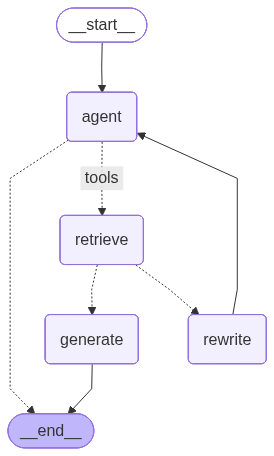

In [14]:
# Producing the StateGraph
from langgraph.graph import START, END, StateGraph 
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([Retriever_tool_1, Retriever_tool_2])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant

# Edges
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called
# After the grade_documents is called, it returns either generate or rewrite 
# That is why it we dont add it in the same workflow of grade_documents
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
graph.invoke({"messages":"What is LangGraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, id='e45c01f2-154b-4ca6-af27-42646cc64d06'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is LangGraph?" I need to figure out which tool to use here. The available tools are LangGraph_Documents and LangChain_Documents. Since the question is about LangGraph itself, the most straightforward approach is to use the LangGraph_Documents function. The parameters require a __arg1, which I assume is the search query. So I\'ll input "What is LangGraph?" into that. I don\'t need to use the LangChain one because the question isn\'t about LangChain. Just make sure the JSON is correctly formatted with the function name and arguments. Let me double-check the syntax to avoid any errors.\n', 'tool_calls': [{'id': '9bgmjyajy', 'function': {'arguments': '{"__arg1":"What is LangGraph?"}', 'name': 'LangGraph_Documents'}, 'type': 'function'}]}, response_meta

In [16]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='da79ff03-d57c-41f0-a293-5820dbc98a33'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is Langchain?" I need to figure out which tool to use here. Looking at the available functions, there\'s one called LangChain_Documents that searches for information about LangChain. The other is for LangGraph. Since the question is about LangChain, I should use the LangChain_Documents function. The parameters require a string argument, which I\'ll use to query the definition or overview of LangChain. I\'ll structure the tool call with the appropriate name and arguments.\n', 'tool_calls': [{'id': 'kn92mr827', 'function': {'arguments': '{"__arg1":"What is LangChain?"}', 'name': 'LangChain_Documents'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 241, 'total_tokens': 381, 'completion_time': 0.27

In [17]:
# In this example, the LLM did not find the need to check for relevance
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='93d53464-7838-43b6-b0c0-e153e74b7a08'),
  AIMessage(content="The functions provided are for searching specific documentation related to LangGraph and LangChain, which are tools within the LangChain ecosystem. Since your question is a general one about the definition of machine learning, these tools are not the best fit for providing an answer. Let me instead provide a straightforward explanation:\n\n**Machine learning** is a subset of artificial intelligence (AI) that focuses on building systems that can learn patterns and make decisions from data without being explicitly programmed for specific tasks. It involves algorithms that improve their performance on a task through experience (i.e., by analyzing data). Key types include:\n- **Supervised learning** (using labeled data to predict outcomes),\n- **Unsupervised learning** (finding patterns in unlabeled data),\n- **Reinforc